In [3]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

# rho
# inv_Q_w
# output da capire
# cluster allocations solo spazio

ModuleNotFoundError: No module named 'cmdstanpy'

In [5]:
dp_mix_stan = """
data {
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    
    matrix[I,T] y; // output values 
    
    int<lower=1> p; // number of covariates
    
    // P_0 (gaussian part)
    vector[p+1]     mu_0;    
    matrix[p+1,p+1] Sigma_0; 
    
    // W
    vector[I]   mu_w_1;
    matrix[I,I] inv_Q_w; // rho*(diag(W*I)-W) + (1-rho) 
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // xi
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    // rho
    // real<lower=0> alpha_rho;
    // real<lower=0> beta_rho;
    
    int<lower=1> H; // truncation of stick breaking construction dp
    
    int<lower=1>  ngrid; // plot stuff 
    vector[ngrid] xgrid;
    
    matrix[I*T,p+1] X; // covariate matrix
}

parameters {
    real<lower=0> alpha;                     // mass parameter of dp
    matrix[p+1,H] betas;                     // regressors
    matrix<lower=0,upper=1>[I,H]   xis_constructors;     // autoregressive coefficients
    matrix[I,T]   ws;                        // random effects
    real<lower=0> sigma2;                    // output variance
    real<lower=0> tau2;
    real<lower=0> rho;
    
    vector<lower=0,upper=1>[H-1] vs; // needed to construct omegas
}

transformed parameters {
    real<lower=0> sigma = sqrt(sigma2); // output sd
    
    simplex[H] omegas; // weights of sbc
    
    // construct omegas
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
}

model {
    alpha  ~ gamma(a_alpha, b_alpha);
    vs     ~ beta(1,alpha);
    sigma2 ~ inv_gamma(a_sigma2, b_sigma2);
    tau2   ~ inv_gamma(a_tau2, b_tau2);
    //rho    ~ beta(alpha_rho, beta_rho);
    
    for (h in 1:H) {
        betas[1:p+1,h] ~ multi_normal(mu_0, Sigma_0); // P_0 of dp
    }
    matrix[I,H] xis;
    for (h in 1:H) {
        for (i in 1:I) {
            xis_constructors[i,h] ~ beta(a_xi, b_xi);
            xis[i,h]=2*xis_constructors[i,h]-1;
        }
    }
    ws[1:I,1] ~ multi_normal(mu_w_1, tau2*inv_Q_w);
    
    for (t in 2:T){
        for(h in 1:H){
        ws[1:I,t] ~ multi_normal(diag_matrix(xis[1:I,h])*ws[1:I,t-1], tau2*inv_Q_w);
        }
    }
    
    for (t in 1:T) {
        for (i in 1:I){
            vector[H] log_probas;
            for (h in 1:H) {
                log_probas[h] = 
                    log(omegas[h]) + normal_lpdf(y[i,t] | dot_product(X[i,1:p+1],betas[1:p+1,h]) + ws[i,t], sigma);
            }
            target += log_sum_exp(log_probas);
        }
    }
    
}

generated quantities {
    
    // allocation just in space not also in time @TODO
    /*vector[I*T] s; // cluster allocations
    
    for (t in 1:T) {
        for (i in 1:I) {
            vector[H] log_probas;
            for (h in 1:H) {
                log_probas[h] = log(omegas[h]) + normal_lpdf(y[i,t] | dot_product(X[i,1:p+1],betas[1:p+1,h]), sigma);
            }
        s[i] = categorical_rng(softmax(log_probas));
    }
   }*/
    
    // generated quantities with random effect ?
    /*vector[ngrid] dens; // evaluate densities on grid (same dimension of data for now)

     for (i in 1:ngrid) {
        vector[H] log_probas;
        for (h in 1:H) {
            log_probas[h] = log(omegas[h]) + normal_lpdf(xgrid[i] | dot_product(X[i,1:p+1],betas[1:p+1,h]) , sigma);
        }
        dens[i] =  exp(log_sum_exp(log_probas));
    }*/
}

"""

stan_file = "dirichlet.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dpm_stan = CmdStanModel(stan_file=stan_file)

NameError: name 'CmdStanModel' is not defined

In [14]:
## generate some data

I = 10
T = 10
ndata = 100
means = np.array([-5, 0, 5])
true_clus = np.random.choice(np.arange(3), size=ndata)

data = np.random.normal(loc=means[true_clus]).reshape(10,10)

mu_w_1 = np.zeros(10)

inv_Q_w = np.eye(10) + 1

mu_0 = np.array([1,1,1,1])
Sigma_0 = np.eye(4)
X = np.zeros((100,4))

for i in range(100):
    X[i,:] = np.array([1,2,3,4])
    
xgrid = np.linspace(-10,10,100);

a_alpha = 3
b_alpha = 2 

a_tau2 = 3
b_tau2 = 2

a_sigma2 = 3
b_sigma2 = 2

a_xi = 1
b_xi = 1

alpha_rho = 3
beta_rho = 2

stan_data = {
    "I": I,
    "T": T,
    "p": 3,
    "y": data,
    "H": 10,
    "mu_0": mu_0,
    "Sigma_0" : Sigma_0,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_xi": 1,
    "b_xi": 1,
    "a_sigma2": a_sigma2,
    "b_sigma2": b_sigma2,
    "mu_w_1": mu_w_1,
    "inv_Q_w": inv_Q_w,
    "ngrid":len(xgrid),
    "xgrid": xgrid,
    "X": X    
}

fit = dpm_stan.sample(stan_data, show_console = "true")

17:53:25 - cmdstanpy - INFO - Chain [1] start processing
17:53:25 - cmdstanpy - INFO - Chain [2] start processing
17:53:25 - cmdstanpy - INFO - Chain [3] start processing
17:53:25 - cmdstanpy - INFO - Chain [4] start processing
17:53:25 - cmdstanpy - INFO - Chain [1] done processing
17:53:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
17:53:25 - cmdstanpy - INFO - Chain [2] done processing
17:53:25 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
17:53:25 - cmdstanpy - INFO - Chain [3] done processing
17:53:25 - cmdstanpy - INFO - Chain [4] done processing
17:53:25 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted
17:53:25 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [2] method = sample (Default)
Chain [2] sample
Chain [2] num_samples = 1000 (Default)
Chain [2] num_warmup = 1000 (Default)
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [1]       kappa = 0.75 (Default)
Chain [1]       t0 = 10 (Default)
Chain [1]       init_buffer = 75 (Default)
Chain [1]       term_buffer = 50 (Default)
Chain [1]       window = 25 (Default)
Chain [1]     algorithm = hmc (Default)
Chain [1]       hmc
Chain [1]         engine = nuts (Default)
Chain [1]           nuts
Chain [1]             max_depth = 10 (Default)
Chain [1]         metric = diag_e (Default)
Chain [1]         metric_file =  (Default)
Chain [

RuntimeError: Error during sampling:
Exception: beta_lpdf: Random variable is -0.332727, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.713871, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0226298, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.340488, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0287196, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.408665, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0276255, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.436832, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0989015, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.452561, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.330073, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.684918, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.224895, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.6894, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.186533, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.554776, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.509334, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.567746, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.505596, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.159876, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.31906, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.358982, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.491553, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.57888, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.469869, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.558776, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.392509, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.649321, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.214607, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.478232, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.633081, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.726743, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.131792, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.635917, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.245087, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.728744, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.236389, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.386895, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.292453, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.528401, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.565233, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.102001, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.118379, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.116263, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.105822, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.190553, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.593445, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.441665, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.366444, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.565822, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.670906, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.745895, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.614422, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0676013, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.377677, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0777014, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.28179, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.724445, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.214651, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.459121, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.615973, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.398148, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.352023, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.554456, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.489063, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.672136, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.194649, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.425918, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.681718, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.270242, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0516324, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.614067, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.508382, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.29375, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.201264, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.536091, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.205303, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0109306, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.27776, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0068014, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.75334, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.372378, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.561829, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.200207, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.368299, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.705251, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.73274, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.168024, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.372736, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.377334, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.13828, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.149511, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.116686, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.354624, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.445342, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.718947, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0591754, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.097561, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.619841, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.174053, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
Exception: beta_lpdf: Random variable is -0.74376, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.664142, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.605035, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.472689, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.123911, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.15443, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.753728, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.713253, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.722003, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.490242, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.388604, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.4219, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.582373, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.588322, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.705543, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.476908, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.400633, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.447799, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.627912, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.495709, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.413758, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0569164, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.498439, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0236151, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.265076, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0127249, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.429549, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.299008, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.227386, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.180749, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0187387, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.747641, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.39491, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.724292, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.711577, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.707796, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.746989, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.303221, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.522903, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.549176, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.651242, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.678722, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.748539, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.531661, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.748435, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.203427, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.196856, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.4176, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.753085, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.756864, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.710125, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.579377, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.722975, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.278769, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.282812, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0751721, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0846456, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.738084, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.641885, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.118036, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.32155, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.633608, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.466961, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.375073, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.760026, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.364356, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.297958, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.717381, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.758161, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0130678, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.392151, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.174563, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.53174, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.707793, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.560217, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.367861, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.734244, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.712953, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.514669, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.697609, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.590775, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.496734, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.158922, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.184163, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.283657, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0936937, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.506665, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0155563, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.394845, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.430897, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.243095, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.352136, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.734556, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.703647, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.528572, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.38379, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.368233, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.299578, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.504662, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.335621, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
Exception: beta_lpdf: Random variable is -0.713177, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.732452, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.459073, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.644715, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.371902, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.384428, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.475116, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.221578, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.482528, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.632424, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.53001, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.509341, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.170331, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.491119, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0297362, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.216697, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.444818, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.50291, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.54863, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.680293, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.563644, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.638747, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.36121, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.558813, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.54504, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.665733, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.645956, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.550345, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.639624, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.641704, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.664057, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.234195, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0433589, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.502596, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.380251, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.363992, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.166519, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.544345, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0324474, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.279069, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.570103, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.729885, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.13301, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.598955, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.518507, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0315909, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.619195, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.185741, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.459365, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.623756, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.601263, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.435458, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.57085, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.55282, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.737394, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.760629, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.350322, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.166266, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.26192, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.510896, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.572726, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.158484, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.741197, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.136115, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.285332, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.415729, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.234809, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.698368, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.759411, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.573806, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.267704, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.00644224, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.608162, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.540186, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0523368, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.480688, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.64009, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.164484, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.267793, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0240858, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.437209, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.28161, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.759289, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.754601, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.666537, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.71504, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.613067, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.441958, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.737739, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.554554, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.309856, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.686134, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.571737, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.591499, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.404359, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.251367, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.219618, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.746777, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.753963, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.635683, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
Exception: beta_lpdf: Random variable is -0.0450401, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0565853, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.236486, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.420361, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.309274, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.356991, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.189682, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.575179, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0054554, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.11223, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.357778, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.214447, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.601613, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.315666, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.394248, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0764084, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.176856, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.520936, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.676658, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0296043, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.654803, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.318087, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.328058, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.639251, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.636712, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.497741, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.749261, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.578204, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.00128237, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.577444, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.649371, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.610382, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.164051, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.569896, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.66828, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.627823, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.581079, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.748423, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.286895, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.1674, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.156359, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.318685, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.310102, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.641716, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.226854, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.575046, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.102463, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.438964, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.386611, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.453463, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0102483, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.604727, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.00828002, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.649445, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.688119, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.379263, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.701404, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.36606, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.523979, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0241122, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0465576, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.333134, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.394626, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.473695, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.058348, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.198315, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.295764, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.166359, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.719398, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0640472, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0168263, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.206191, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0956102, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.260707, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.319806, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.54705, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.558345, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.003528, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.645523, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.211486, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.719252, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0806181, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.0175286, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.257184, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.701045, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.354377, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.684823, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.504447, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.117693, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.725168, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.384379, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.572058, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.129001, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.672497, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.749871, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.697849, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.744745, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.539464, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.41707, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
	Exception: beta_lpdf: Random variable is -0.134872, but must be in the interval [0, 1] (in '/home/riccardo/bayesian-project/dirichlet.stan', line 85, column 12 to column 40)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/home/riccardo/bayesian-project/dirichlet', 'id=1', 'random', 'seed=52468', 'data', 'file=/tmp/tmptzk3cvqq/ooer9v23.json', 'output', 'file=/tmp/tmptzk3cvqq/dirichletzkwfivl0/dirichlet-20221212175325_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmptzk3cvqq/dirichletzkwfivl0/dirichlet-20221212175325_1.csv
 console_msgs (if any):
	/tmp/tmptzk3cvqq/dirichletzkwfivl0/dirichlet-20221212175325_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

/home/daan/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


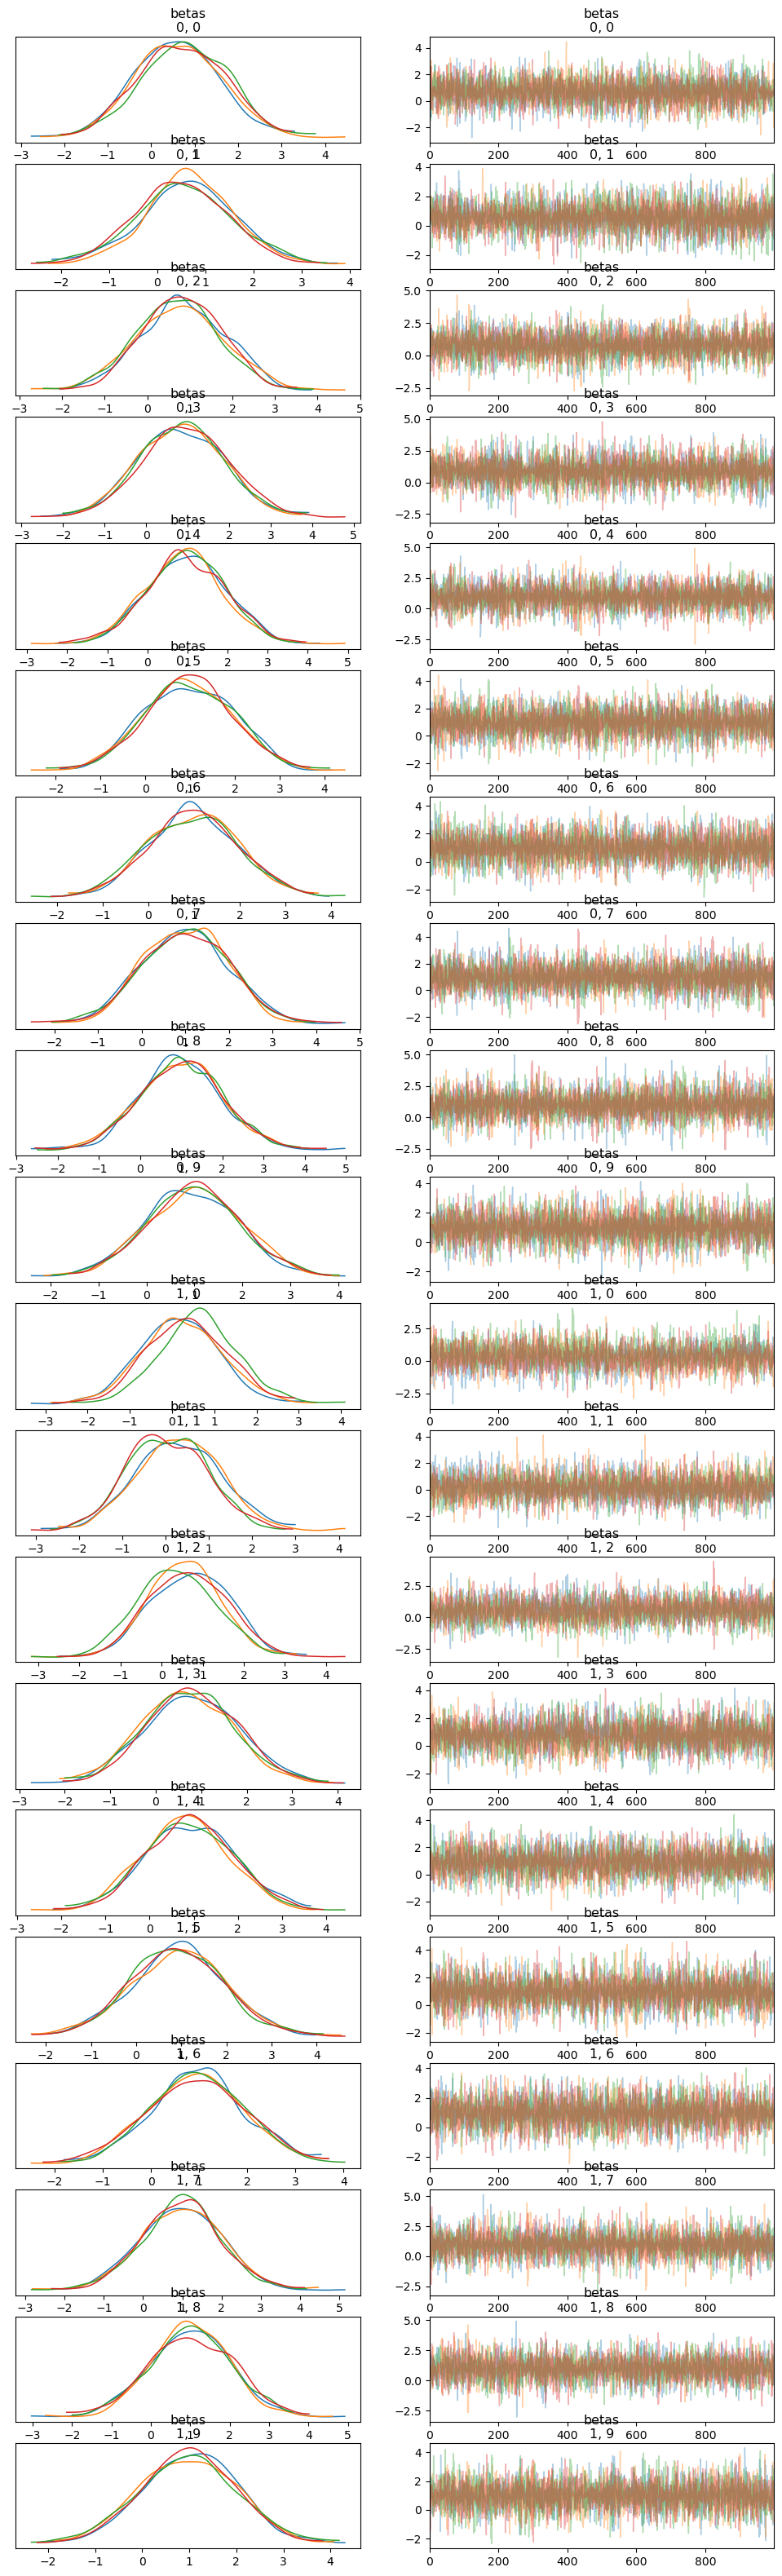

In [25]:
## plot no sense
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()